In [9]:
%reload_ext autoreload
%autoreload 3

from main.utils import funcs

%reload_ext main.utils.funcs

/opt/homebrew/Caskroom/miniforge/base/envs/paper_miniforge/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:207: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize(img, size, interpolation=Image.BILINEAR):
/opt/homebrew/Caskroom/miniforge/base/envs/paper_miniforge/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:280: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def perspective(img, perspective_coeffs, interpolation=Image.BICUBIC, fill=None):
2022-11-04 02:31:45.919380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-04 02:31:45.919645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Create

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Loading the experiment results from MLFlow

In [10]:
dir = '/Users/personal-macbook/Documents/PhD/dataset/chexpert/CheXpert-v1.0-small'
aim1_1 = funcs.AIM1_1_TorchXrayVision(dir=dir)
output = aim1_1.load_results_from_MLFlow()

Connecting to the server...






************************************************
Access is restricted to AUTHORIZED USERS only! If
you are not authorized LEAVE NOW!
************************************************



bind [127.0.0.1]:5000: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 5000
Could not request local forwarding.


Killing all active runs...
Setting up the experiment...
setting the tracking URI
setting/creating the experiment


In [12]:
pred = output.pred.copy()
loss = output.loss_per_class.copy()
truth = output.truth.copy()

hierarchy = { 'Lung Opacity': ['Pneumonia', 'Atelectasis','Consolidation','Lung Lesion', 'Edema'] ,  'Enlarged Cardiomediastinum':  ['Cardiomegaly']  }
parent_class = 'Lung Opacity'
its_children = hierarchy[parent_class]
classes_to_show = [parent_class] + its_children

## Finding the optimum threshold

There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.
The true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

```python
        Sensitivity = TP / (TP + FN)  = TPR
        Specificity = TN / (FP + TN)  = 1 – FPR
```

The Geometric Mean or `G-Mean`  is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

```python
        G-Mean = sqrt(Sensitivity * Specificity) 
```

One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

In [14]:
import sklearn
from sklearn import metrics
import numpy as np
import pandas as pd


# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(truth[parent_class], pred[parent_class])

df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.579333, G-Mean=0.791


It turns out there is a much faster way to get the same result, called the Youden’s J statistic.

The statistic is calculated as:

```python
        J = Sensitivity + Specificity - 1 = TPR -FPR
```

We can then choose the threshold with the largest `J` statistic value.

In [15]:
J = tpr - fpr
ix = np.argmax(J)
print(f'Best Threshold={ thresholds[ix] } ')

Best Threshold=0.579332709312439 


#### Optimal Threshold for Precision-Recall Curve

Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.

```python
        Precision = TP / (TP + FP)
        Recall = TP / (TP + FN)
``` 
- Precision describes how good a model is at predicting the positive class. 
- Recall is the same as sensitivity.

A precision-recall curve is calculated by creating crisp class labels for probability predictions across a set of thresholds and calculating the precision and recall for each threshold. 

A line plot is created for the thresholds in ascending order with recall on the x-axis and precision on the y-axis.

A no-skill model is represented by a horizontal line with a precision that is the ratio of positive examples in the dataset (e.g. TP / (TP + TN)), or 0.01 on our synthetic dataset. perfect skill classifier has full precision and recall with a dot in the top-right corner.

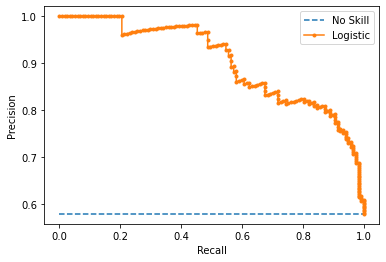

In [16]:
from matplotlib import pyplot

# calculate pr-curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve( truth[parent_class] , pred[parent_class] ) # type: ignore

# plot the roc curve for the model
no_skill = len(truth[parent_class][truth[parent_class]==1]) / len(truth[parent_class])
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-measure that summarizes the harmonic mean of both measures.
```python
        F1 = 2 * (precision * recall) / (precision + recall)
```

As in the previous section, the naive approach to finding the optimal threshold would be to calculate the F-measure for each threshold. We can achieve the same effect by converting the precision and recall measures to F-measure directly; for example:

Best Threshold=0.551205, F-Score=0.845


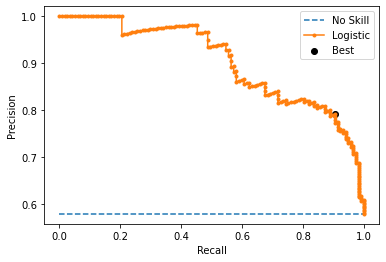

client_loop: send disconnect: Broken pipe


In [17]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(truth[parent_class][truth[parent_class]==1]) / len(truth[parent_class])
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()